In [1]:
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
data = pd.read_excel('https://www.oliviergueant.com/uploads/4/3/0/9/4309511/sbf120_as_of_end_2018.xlsx', sheet_name = 'Data')

In [3]:
%%time

price_df_list = []
for i in tqdm(range(120)):
    price_data = data.iloc[:,3*i:3*i+2].copy()
    price_data.dropna(inplace=True)
    price_data.iloc[:,0] = pd.to_datetime(price_data.iloc[:,0], unit= 'D', origin= '1899-12-30')
    price_data.rename(columns = {price_data.columns[0] : 'Date', price_data.columns[1]: price_data.columns[0]}, inplace = True)
    price_data.set_index('Date', inplace = True)
    price_df_list.append(price_data)

agg_price_data = price_df_list[0]
for df in tqdm(price_df_list[1:]):
    agg_price_data = agg_price_data.join(df, how='outer', sort = True)

100%|██████████| 119/119 [00:00<00:00, 739.43it/s]

CPU times: user 377 ms, sys: 68.1 ms, total: 445 ms
Wall time: 489 ms


In [4]:
for ticker in agg_price_data.columns:
    series = agg_price_data[ticker]
    first = series.first_valid_index()
    last = series.last_valid_index()
    series_real = series[(series.index >= first) & (series.index <= last)].fillna(method = 'bfill')
    agg_price_data[ticker][(agg_price_data[ticker].index >= first) & (agg_price_data[ticker].index <= last)] = series_real

In [5]:
bnp_prices = agg_price_data['BNP FP Equity']['2019':]
sg_prices = agg_price_data['GLE FP Equity']['2019':]

In [6]:
fontsize = 9
width_in_cm = 14.
params = {'figure.figsize': (width_in_cm / 2.54, width_in_cm / 2.54 * 9./16.),
          'axes.labelsize': fontsize,
          'axes.titlesize': fontsize,
          'xtick.labelsize': fontsize*0.75,
          'ytick.labelsize': fontsize*0.75,
          'legend.fontsize': fontsize*0.75}
plt.rcParams.update(params)

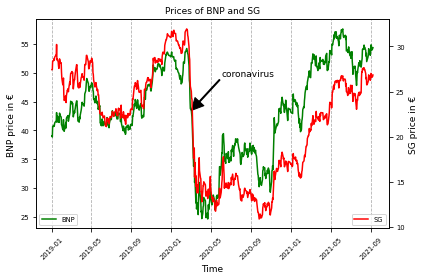

In [7]:
fig, axbnp = plt.subplots(1,1)
axsg = axbnp.twinx()
axbnp.plot(bnp_prices, 'g', label = 'BNP')
axsg.plot(sg_prices, 'r', label = 'SG')
axbnp.set_xlabel('Time')
axbnp.set_ylabel('BNP price in €')
axsg.set_ylabel('SG price in €')
axbnp.legend(loc=3)
axsg.legend(loc=4)
axbnp.tick_params(axis='x', rotation=45)
axbnp.set_title('Prices of BNP and SG')
axbnp.annotate('coronavirus', xy=(datetime(2020, 3, 2), bnp_prices[datetime(2020, 3, 2)]),
            xytext=(datetime(2020, 6, 2), bnp_prices[datetime(2020, 3, 2)]+6), fontsize=fontsize, arrowprops={'facecolor': 'black', 'width': 1})
axbnp.grid(axis='x', linestyle='--')
fig.tight_layout()
fig.savefig('prices.pdf')
plt.show()

In [8]:
bnp = agg_price_data[['BNP FP Equity']].pct_change().dropna()['2019':]
bnp.rename(columns = {'BNP FP Equity' : 'daily price return'}, inplace = True)
bnp['ticker'] = 'BNP FP Equity'
bnp

sg = agg_price_data[['GLE FP Equity']].pct_change().dropna()['2019':]
sg.rename(columns = {'GLE FP Equity' : 'daily price return'}, inplace = True)
sg['ticker'] = 'GLE FP Equity'
sg

data_returns = pd.concat([bnp, sg])
data_returns['Year'] = data_returns.index.year

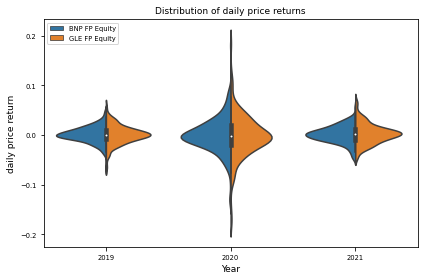

In [9]:
fig, ax = plt.subplots(1,1)
#sns.set_theme(style='white')
sns.violinplot(ax=ax, data=data_returns, x='Year', y='daily price return', hue='ticker', split=True)
ax.set_title('Distribution of daily price returns')
ax.legend(loc=2)
fig.tight_layout()
plt.savefig('violin.pdf')
plt.show()

In [10]:
data_returns = agg_price_data[['BNP FP Equity', 'GLE FP Equity']].pct_change().dropna().loc['2019':]
data_returns['year'] = data_returns.index.year

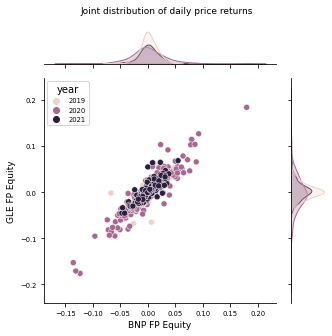

In [11]:
p = sns.jointplot(data=data_returns, x='BNP FP Equity', y='GLE FP Equity', hue='year', height=12./2.54)
p.fig.suptitle('Joint distribution of daily price returns', fontsize=fontsize)
p.fig.tight_layout()
plt.savefig('jointplot.pdf')
plt.show()